<img align="right" width="100" height="100" src="https://jatinangor.itb.ac.id/wp-content/uploads/sites/17/2012/12/Logo-ITB-polos20-1.jpg">

## Seismologi Komputasi - Tugas 2
*Farhan Hamid Lubis - 22319310*<br>
*Rizky Adityo Prastama - 22319311*
***
#### Pemodelan Raytracing - 1D Gradient Velocity Layered Earth Model

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)
np.set_printoptions(threshold=sys.maxsize)
%matplotlib inline

#### Step 1 : Input Parameter

Di bawah ini adalah parameter yang digunakan dalam ray tracing pada medium dengan gradien kecepatan konstan yang disimpan dalam variabel sebagai berikut:

    * rays : integer
        Jumlah ray seismik
    * velo_i : integer
        Nilai cepat rambat gelombang awal V0
    * velo_f : integer
        Nilai cepat rambat gelombang akhir V(z)
    * layers : integer
        Jumlah lapisan 
    * depth : 1D-array
        Kedalaman masing-masing lapisan
    * dz : 1D-array
        Ketebalan masing-masing lapisan
    

In [2]:
rays   = 1
inc_z  = 1
z      = np.array([1000])
velo_i = np.array([4000])
velo_f = np.array([2000])
layers = np.shape(z)[0]

depth = np.zeros([1, layers+1])
for i in range(1, layers + 1):
    depth[0, 0] = 0
    depth[0, i] = depth[0, i - 1] + z[i - 1]

In [3]:
dz = np.zeros([1, 1])
for i in range(layers):
    a = np.transpose(np.amax(dz) + 
                     np.array([np.arange(1, z[i]+1, inc_z)]))
    dz = np.append(dz, a, axis = 0)

#### Step 2 : Perhitungan Gradient Velocity

Besar kecepatan medium mengikuti persamaan:

$$
V(z) = V_{0} + bz
$$

Dengan menggunakan persamaan di atas, nilai gradien ($b$) adalah:

$$
b = \frac{V(z) - V_{0}}{z}
$$

dimana $V(z)$ adalah kecepatan medium pada titik $z$, $V_{0}$ adalah kecepatan pada titik awal, dan $z$ adalah jarak atau ketebalan medium. Hasil perhitungan pada tahap ini disimpan pada variabel berikut:

    * b : 1D-array
        Nilai gradien velocity lapisan

In [4]:
b = np.zeros([1, layers])
for i in range(layers):
    b[0, i] = (velo_f[i] - velo_i[i]) / z[i]

#### Step 3 : Perhitungan Slowness Vector Components
Perhitungan dilakukan pada bidang $(x, z)$ dengan $y = 0$ sehingga komponen vektor slowness arah y ($p_{y}$) bernilai 0. Medium memiliki velocity homogen secara lateral sehingga:

$$
p_{x} = p = \sin{i(z)}/V(z)
$$

dimana $i$ adalah sudut takeoff dan $V(z)$ adalah nilai kecepatan pada kedalaman $z$. Dengan menggunakan persamaan eikonal $p_{x}^{2} + p_{z}^{2} = V^{-2}$, maka $p_{z_{0}}$ dapat dihitung sebagai berikut: 

$$
p_{z_{0}} = \sqrt{V_{0}^{-2} - p^{2}}
$$

Di bawah ini adalah looping untuk memperoleh sudut takeoff $(i)$, $p$, dan $p_{z}$ yang disimpan dalam variabel berikut:

    * p : 1D-array
        Nilai horizontal slowness (px) untuk masing-masing ray
    * pz : 2D-array
        Nilai vertical slonwess (pz) masing-masing ray dengan menggunakan V0 di titik awal

In [5]:
# perhitungan nilai sudut takeoff
theta = np.zeros([1, rays])
diff = 10 # perbedaan sudut setiap gelombang
for i in range(0, rays):
    theta[0, i] = (1 + i) * diff

In [6]:
p = np.zeros([1, rays])
for i in range(rays):
    p[0, i] = np.sin(np.deg2rad(theta[0, i])) / velo_i[0]

pz = np.zeros([layers, rays])
for j in range(rays):
    for i in range(layers):
        pz[i, j] = np.sqrt((1/(velo_i[i]))**(2) - (p[0, j])**2)

#### Step 4 : Perhitungan Lateral Displacement
Akibat kecepatan medium yang memiliki gradien, perambatan gelombang pada medium menjadi melingkar. Cerveny mendefinisikan perpindahan lateral gelombang pada arah $x$ sebagai fungsi kedalaman $z$ dan besar gradien $b$ sebagai berikut:

$$
\left[x - x_{0} - \frac{p_{z_{0}} V_{0}}{b p} \right]^{2} + \left[z - z_{0} - \frac{V_{0}}{b} \right]^{2} = \frac{1}{p^{2} b^{2}}
$$

Dengan menyusun ulang persamaan di atas, diperoleh:

$$
x = \sqrt{\frac{1}{p^{2} b^{2}} - \left[z - z_{0} - \frac{V_{0}}{b} \right]^{2}} + x_{0} + \frac{p_{z_{0}} V_{0}}{b p}
$$

Hasil perhitungan pada tahap ini disimpan dalam variabel berikut:

    * x : 1D-array
        Nilai lateral displacement di setiap kedalaman (z) 

In [7]:
x = np.zeros([np.shape(dz)[0], rays])

for j in range(rays):
    for k in range(layers):
        for i in range(int(depth[0, k]) + 1, int(depth[0, k + 1]) + 1):
            var1 = 1 / ((p[0, j]**2) * (b[0, k])**2)
            var2 = (dz[i, 0] + (velo_i[k] / b[0, k]))**2
            var3 = (pz[k, j] * velo_i[k]) / (b[0, k] * p[0, j])
            x[i, j] = np.sqrt(var1 - var2) + x[int(depth[0, k]), j] + var3
            

#### Step 5 : Visualisasi

Berikut merupakan perintah untuk melakukan visualiasi ray tracing dengan sumber berada pada lapisan (z)

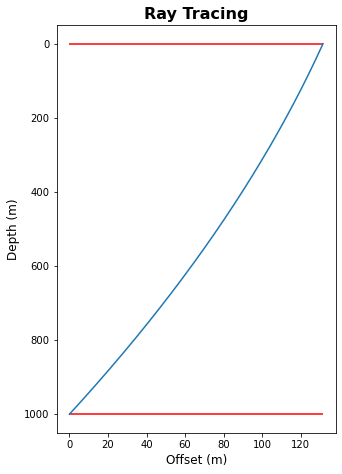

In [8]:
fig, ax = plt.subplots()
for i in range(rays):
    ax.plot(x[:, i], np.flip(dz[:, 0], 0))
ax.set_title("Ray Tracing", fontdict = {'fontsize': 16, 'fontweight': 'bold'})
ax.set_xlabel("Offset (m)", fontdict = {'fontsize': 12, 'fontweight': 'medium'})
ax.set_ylabel("Depth (m)", fontdict = {'fontsize': 12, 'fontweight': 'medium'})
plt.gca().invert_yaxis()
for i in range(len(depth)):
    plt.hlines(depth[i], 0, np.amax(x), colors='r')
fig.set_size_inches(5, 7.5)

***
### References

ČErvený V. (1989) Seismic ray theory. In: Geophysics. Encyclopedia of Earth Science. Springer, Boston, MA. https://doi.org/10.1007/0-387-30752-4_134